In [1]:
import numpy as np
import pandas as pd
import torch

from tqdm import tqdm
from collections import defaultdict, Counter
from scipy import stats
from itertools import combinations, islice
from sklearn import preprocessing

from news_vec.utils import read_json_gz_lines

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
def make_key(d1, d2):
    return tuple(sorted([d1, d2]))

In [29]:
counts_iter = islice(read_json_gz_lines('../../data/actor-domain-counts.json/'), None)

ACTOR_DOMAIN_COUNTS = {
    (row['actor_id'], row['domain']): np.log(row['count'])
    for row in tqdm(counts_iter)
}

18179136it [01:37, 186929.52it/s]


In [30]:
ACTORS = list(set([aid for aid, _ in ACTOR_DOMAIN_COUNTS.keys()]))

In [31]:
DOMAINS = list(set([d for _, d in ACTOR_DOMAIN_COUNTS.keys()]))

In [32]:
DOMAIN_COUNTS_BY_ACTOR = defaultdict(list)

for aid in tqdm(ACTORS):
    for d in DOMAINS:
        DOMAIN_COUNTS_BY_ACTOR[d].append(ACTOR_DOMAIN_COUNTS.get((aid, d), 0))

100%|██████████| 8204693/8204693 [01:35<00:00, 85619.48it/s]


In [33]:
pairs = [make_key(d1, d2) for d1, d2 in combinations(DOMAINS, 2)]

In [34]:
rows = []
for d1, d2 in tqdm(pairs):
    
    c1, c2 = DOMAIN_COUNTS_BY_ACTOR[d1], DOMAIN_COUNTS_BY_ACTOR[d2]
    
    sp_corr, sp_p = stats.spearmanr(c1, c2)
    pr_corr, pr_p = stats.pearsonr(c1, c2)
    kt_corr, kt_p = stats.kendalltau(c1, c2)
    
    rows.append((d1, d2, sp_corr, sp_p, pr_corr, pr_p, kt_corr, kt_p))

100%|██████████| 120/120 [18:22<00:00,  8.97s/it]


In [35]:
df = pd.DataFrame(rows, columns=('d1', 'd2', 'sp_corr', 'sp_p', 'pr_corr', 'pr_p', 'kt_corr', 'kt_p'))

In [36]:
for c1, c2 in combinations(['sp_corr', 'kt_corr', 'pr_corr'], 2):
    print(c1, c2, stats.kendalltau(df[c1], df[c2]))

sp_corr kt_corr KendalltauResult(correlation=0.9901960784313724, pvalue=7.109231145024855e-58)
sp_corr pr_corr KendalltauResult(correlation=0.9190476190476189, pvalue=4.1748498854224865e-50)
kt_corr pr_corr KendalltauResult(correlation=0.9126050420168066, pvalue=1.9759021881958735e-49)


In [37]:
df['sp_scaled'] = preprocessing.scale(df.sp_corr)
df['pr_scaled'] = preprocessing.scale(df.pr_corr)
df['kt_scaled'] = preprocessing.scale(df.kt_corr)

In [38]:
df['pair'] = df[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', 1)

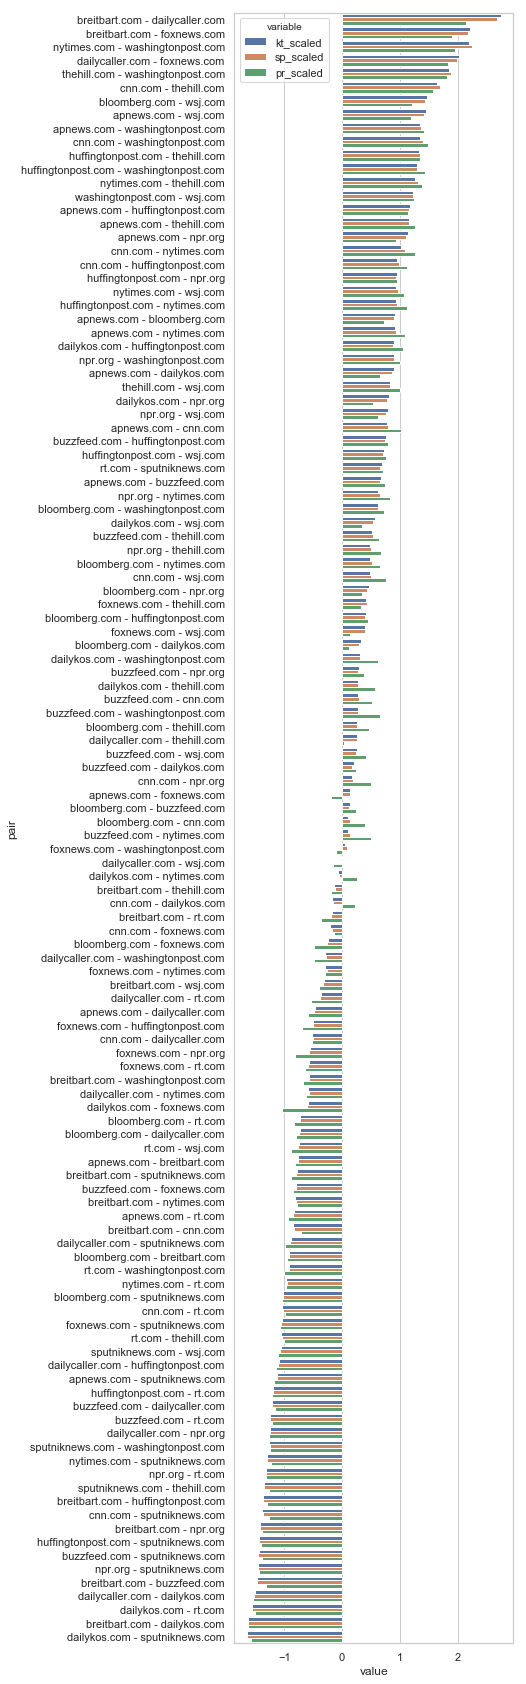

In [39]:
pdf = pd.melt(df, ['pair'], ['kt_scaled', 'sp_scaled', 'pr_scaled'])
order = pdf[pdf.variable=='kt_scaled'].sort_values('value', ascending=False).pair
plt.figure(figsize=(5,30))
sns.barplot(x='value', y='pair', data=pdf, hue='variable', order=order)

In [40]:
df.to_json('data/audience-graph.json', orient='records', lines=True)